In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch 
from torch import nn
from torch.utils.data import DataLoader
import transformers

import matplotlib.pyplot as plt

sys.path.append('../../models')
from utils import *

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


# Data Preparation

In [2]:
bos = False

In [3]:
train_max_sequence_length = 256
train_dataset_size = 8192
train_dataset = InductionDataset(
    train_max_sequence_length, 
    dataset_size=train_dataset_size,
    bos=bos
)

In [4]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=False, 
    drop_last=True, 
    num_workers=4, 
    persistent_workers=True, 
    pin_memory=True
)

In [5]:
max_val_sequence_length = 256
val_dataset_size = 2048
val_dataset = InductionDataset(
    max_val_sequence_length, 
    dataset_size=val_dataset_size, offline=True, 
    bos=bos
)

100%|██████████| 2048/2048 [00:02<00:00, 735.90it/s]


In [6]:
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, drop_last=False, num_workers=4)

In [7]:
max_test_sequence_length = 1024
test_dataset_size = 5000
test_dataset = InductionDataset(
    max_test_sequence_length, 
    dataset_size=test_dataset_size, 
    offline=True,
    bos=bos
)

100%|██████████| 5000/5000 [00:31<00:00, 156.29it/s]


In [8]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=False, num_workers=4)

# Sinusoidal Absolute Position

In [9]:
from sin_abs_pos import GPTConfig, TransformerDecoder

In [10]:
config = GPTConfig(
    seq_len=1024,
    vocab_size_in=train_dataset.vocab_size,
    vocab_size_out=train_dataset.vocab_size,
    n_blocks=2,
    n_heads=8,
    d_model=128,
    is_causal=True,
    qkv_bias=True
)

DEVICE = "cuda:0"
model_name = 'sin_abs_pos'
model = TransformerDecoder(config).to(DEVICE)
logger.info(count_parameters(model))

INFO:utils:400912


In [11]:
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=1024, 
    num_training_steps=100 * 1024,
    num_cycles=2
)

In [12]:
train_losses, eval_losses, accuracies = train(
    model, 
    optimizer, 
    loss_fn,
    train_loader, 
    val_loader,
    DEVICE,
    scheduler=scheduler, 
    epochs=100,
    model_path=os.path.join('trained', f'{model_name}.pt')
)

100%|██████████| 256/256 [00:00<00:00, 321.03it/s]
INFO:utils:Loss_epoch 1: 2.7763792036566883
INFO:utils:Loss_eval 1: 2.7732988726347685
INFO:utils:Accuracy 1: 0.06228841145833333
100%|██████████| 256/256 [00:00<00:00, 329.97it/s]
INFO:utils:Loss_epoch 2: 2.7734446900431067
INFO:utils:Loss_eval 2: 2.7730005867779255
INFO:utils:Accuracy 2: 0.063275146484375
100%|██████████| 256/256 [00:00<00:00, 315.89it/s]
INFO:utils:Loss_epoch 3: 2.77313399547711
INFO:utils:Loss_eval 3: 2.7732175029814243
INFO:utils:Accuracy 3: 0.06307576497395834
100%|██████████| 256/256 [00:00<00:00, 332.85it/s]
INFO:utils:Loss_epoch 4: 2.7602402188349515
INFO:utils:Loss_eval 4: 2.7529350575059652
INFO:utils:Accuracy 4: 0.08394978841145834
100%|██████████| 256/256 [00:00<00:00, 327.15it/s]
INFO:utils:Loss_epoch 5: 2.6920790625736117
INFO:utils:Loss_eval 5: 2.493031400255859
INFO:utils:Accuracy 5: 0.20113118489583334
100%|██████████| 256/256 [00:00<00:00, 327.92it/s]
INFO:utils:Loss_epoch 6: 1.3776496800419409
INFO:

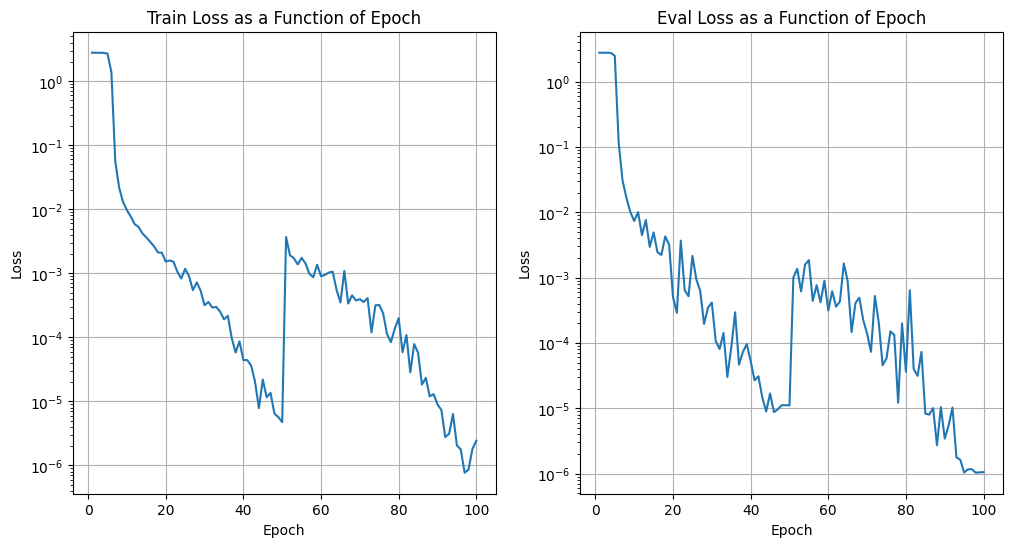

In [15]:
metrics = [
    train_losses, eval_losses
]

titles = [
    'Train Loss as a Function of Epoch',
    'Eval Loss as a Function of Epoch'
]

plt.figure(figsize=(12, 6))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(np.arange(len(metrics[i])) + 1, metrics[i])
    plt.yscale('log')
    plt.title(titles[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

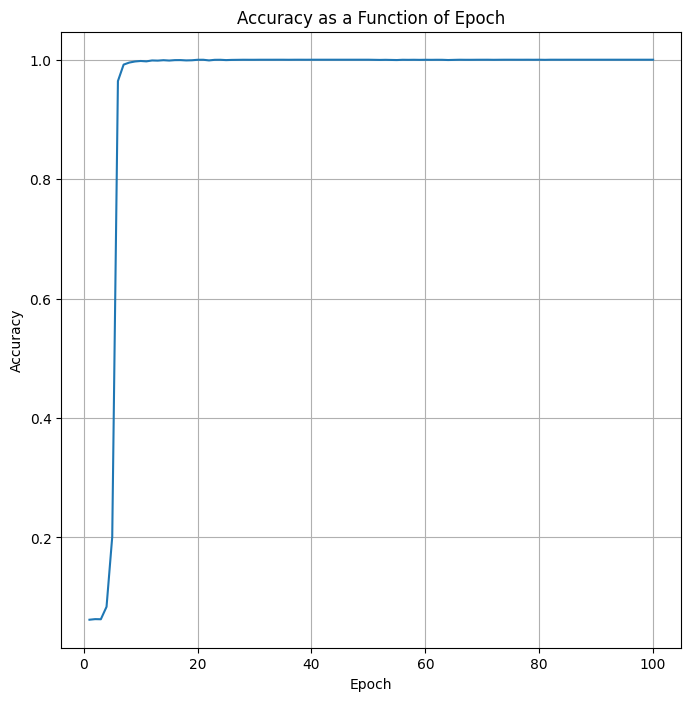

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(len(accuracies)) + 1, accuracies)
plt.title('Accuracy as a Function of Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

In [18]:
pd.DataFrame(
    zip(
        train_losses, 
        eval_losses, 
        accuracies
    ),
    columns=['train_loss', 'eval_loss', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('training_metrics', f'{model_name}.csv'), index=False)

In [19]:
model_path = os.path.join('trained', f'{model_name}.pt')
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

logger.info("Loaded The Model's Dict")

INFO:utils:Loaded The Model's Dict


In [20]:
accuracy = eval_accuracy(model, test_loader, DEVICE, min_len=16, max_len=1024, ignore_index=-1)

100%|██████████| 625/625 [00:04<00:00, 139.96it/s]


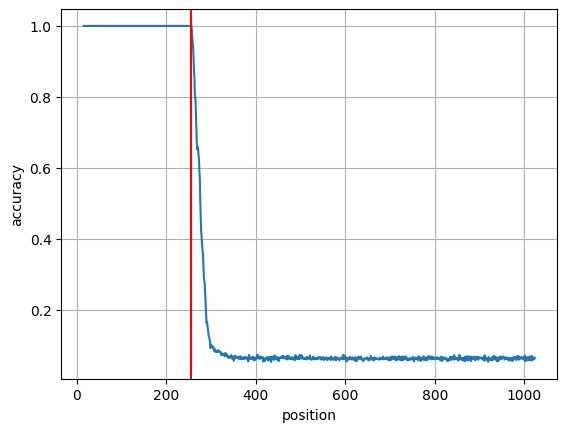

In [21]:
plt.plot(np.arange(16, len(accuracy)+16), accuracy.cpu().detach().numpy())
plt.grid()
plt.xlabel('position')
plt.ylabel('accuracy')
plt.axvline(256, color='r')

In [22]:
pd.DataFrame(
    zip(
        np.arange(16, len(accuracy)+16), 
        accuracy.cpu().detach().numpy(), 
    ),
    columns=['position', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('metrics', f'{model_name}.csv'), index=False)

# ALiBi

In [9]:
from alibi import GPTConfig, TransformerDecoder

In [10]:
config = GPTConfig(
    seq_len=1024,
    vocab_size_in=train_dataset.vocab_size,
    vocab_size_out=train_dataset.vocab_size,
    n_blocks=2,
    n_heads=8,
    d_model=128,
    is_causal=True,
    qkv_bias=True
)

model_name = 'alibi'
DEVICE = "cuda:0"
model = TransformerDecoder(config).to(DEVICE)
logger.info(count_parameters(model))

INFO:utils:400912


In [11]:
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=1024, 
    num_training_steps=100 * 1024,
    num_cycles=2
)

In [12]:
train_losses, eval_losses, accuracies = train(
    model, 
    optimizer, 
    loss_fn,
    train_loader, 
    val_loader,
    DEVICE,
    scheduler=scheduler, 
    epochs=100,
    model_path=os.path.join('trained', f'{model_name}.pt')
)

100%|██████████| 256/256 [00:01<00:00, 225.75it/s]
INFO:utils:Loss_epoch 1: 1.1804521592712263
INFO:utils:Loss_eval 1: 0.21737052273238078
INFO:utils:Accuracy 1: 0.9317769368489583
100%|██████████| 256/256 [00:01<00:00, 212.23it/s]
INFO:utils:Loss_epoch 2: 0.12774479054496624
INFO:utils:Loss_eval 2: 0.07807841287285555
INFO:utils:Accuracy 2: 0.9764302571614584
100%|██████████| 256/256 [00:01<00:00, 232.49it/s]
INFO:utils:Loss_epoch 3: 0.062327298872332904
INFO:utils:Loss_eval 3: 0.05079091339575825
INFO:utils:Accuracy 3: 0.9847981770833333
100%|██████████| 256/256 [00:01<00:00, 237.77it/s]
INFO:utils:Loss_epoch 4: 0.044690196018564166
INFO:utils:Loss_eval 4: 0.03857484079344431
INFO:utils:Accuracy 4: 0.9884053548177083
100%|██████████| 256/256 [00:01<00:00, 225.00it/s]
INFO:utils:Loss_epoch 5: 0.03586186898246524
INFO:utils:Loss_eval 5: 0.03297308386026998
INFO:utils:Accuracy 5: 0.99014892578125
100%|██████████| 256/256 [00:01<00:00, 240.32it/s]
INFO:utils:Loss_epoch 6: 0.0287693461978

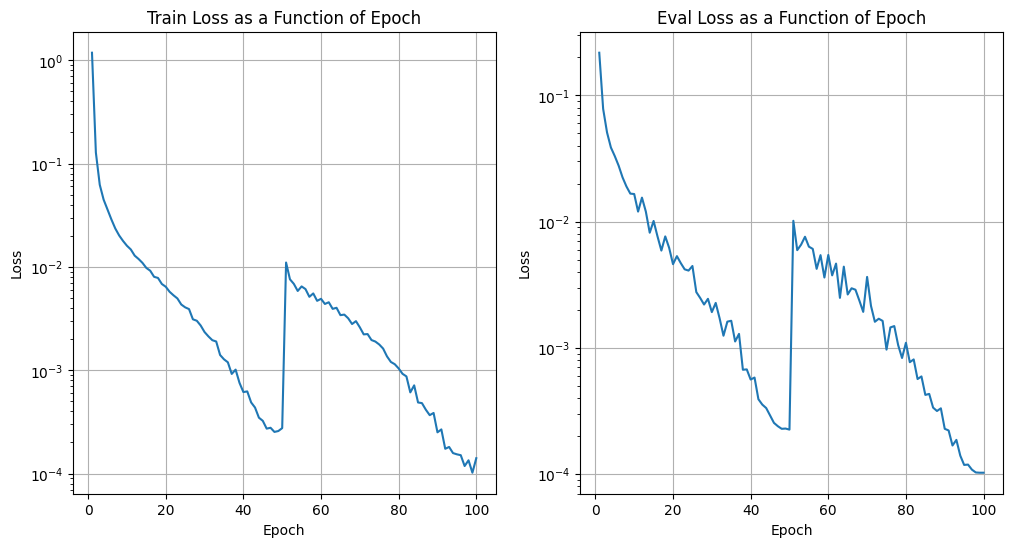

In [13]:
metrics = [
    train_losses, eval_losses
]

titles = [
    'Train Loss as a Function of Epoch',
    'Eval Loss as a Function of Epoch'
]

plt.figure(figsize=(12, 6))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(np.arange(len(metrics[i])) + 1, metrics[i])
    plt.yscale('log')
    plt.title(titles[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

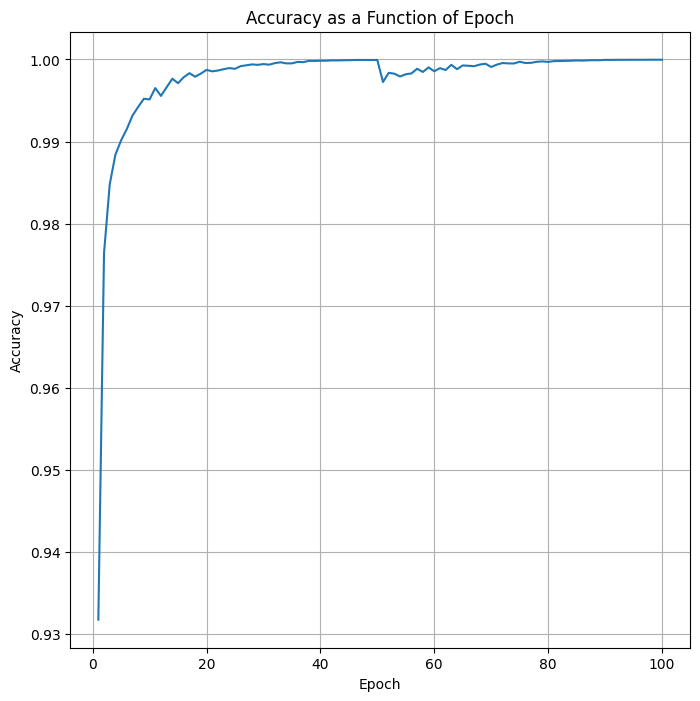

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(len(accuracies)) + 1, accuracies)
plt.title('Accuracy as a Function of Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

In [19]:
pd.DataFrame(
    zip(
        train_losses, 
        eval_losses, 
        accuracies
    ),
    columns=['train_loss', 'eval_loss', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('training_metrics', f'{model_name}.csv'), index=False)

In [15]:
model_path = os.path.join('trained', f'{model_name}.pt')
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

logger.info("Loaded The Model's Dict")

INFO:utils:Loaded The Model's Dict


In [16]:
accuracy = eval_accuracy(model, test_loader, DEVICE, min_len=16, max_len=1024, ignore_index=-1)

100%|██████████| 625/625 [00:28<00:00, 22.10it/s]


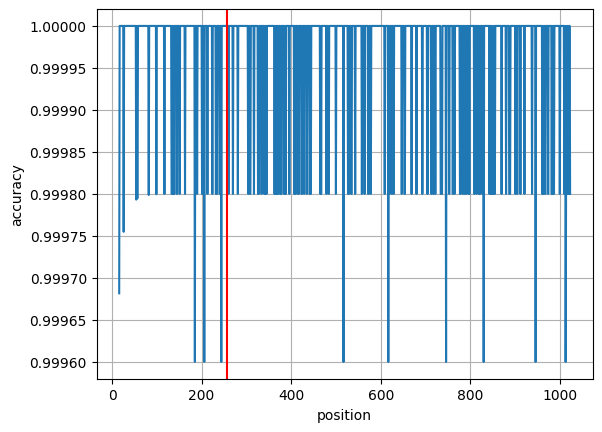

In [17]:
plt.plot(np.arange(16, len(accuracy)+16), accuracy.cpu().detach().numpy())
plt.grid()
plt.xlabel('position')
plt.ylabel('accuracy')
plt.axvline(256, color='r')

In [18]:
pd.DataFrame(
    zip(
        np.arange(16, len(accuracy)+16), 
        accuracy.cpu().detach().numpy(), 
    ),
    columns=['position', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('metrics', f'{model_name}.csv'), index=False)

# RoPE

In [9]:
from rope import GPTConfig, TransformerDecoder

In [10]:
config = GPTConfig(
    seq_len=1024,
    vocab_size_in=train_dataset.vocab_size,
    vocab_size_out=train_dataset.vocab_size,
    n_blocks=2,
    n_heads=8,
    d_model=128,
    is_causal=True,
    qkv_bias=True
)

model_name = 'rope'
DEVICE = "cuda:0"
model = TransformerDecoder(config).to(DEVICE)
logger.info(count_parameters(model))

INFO:utils:400912


In [11]:
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=1024, 
    num_training_steps=100 * 1024,
    num_cycles=2
)

In [12]:
train_losses, eval_losses, accuracies = train(
    model, 
    optimizer, 
    loss_fn,
    train_loader, 
    val_loader,
    DEVICE,
    scheduler=scheduler, 
    epochs=100,
    model_path=os.path.join('trained', f'{model_name}.pt')
)

100%|██████████| 256/256 [00:00<00:00, 291.31it/s]
INFO:utils:Loss_epoch 1: 2.421180809964426
INFO:utils:Loss_eval 1: 1.9149446925148368
INFO:utils:Accuracy 1: 0.36353963216145835
100%|██████████| 256/256 [00:00<00:00, 305.28it/s]
INFO:utils:Loss_epoch 2: 1.5904305971926078
INFO:utils:Loss_eval 2: 1.3056712881661952
INFO:utils:Accuracy 2: 0.5612508138020833
100%|██████████| 256/256 [00:00<00:00, 313.88it/s]
INFO:utils:Loss_epoch 3: 1.0559388150577433
INFO:utils:Loss_eval 3: 0.6979061118327081
INFO:utils:Accuracy 3: 0.7707478841145833
100%|██████████| 256/256 [00:00<00:00, 298.79it/s]
INFO:utils:Loss_epoch 4: 0.1275405036722077
INFO:utils:Loss_eval 4: 0.014332983993881498
INFO:utils:Accuracy 4: 0.9955790201822917
100%|██████████| 256/256 [00:00<00:00, 306.63it/s]
INFO:utils:Loss_epoch 5: 0.012062237023201305
INFO:utils:Loss_eval 5: 0.00802050392030651
INFO:utils:Accuracy 5: 0.9976806640625
100%|██████████| 256/256 [00:00<00:00, 300.72it/s]
INFO:utils:Loss_epoch 6: 0.0082365546904839
INF

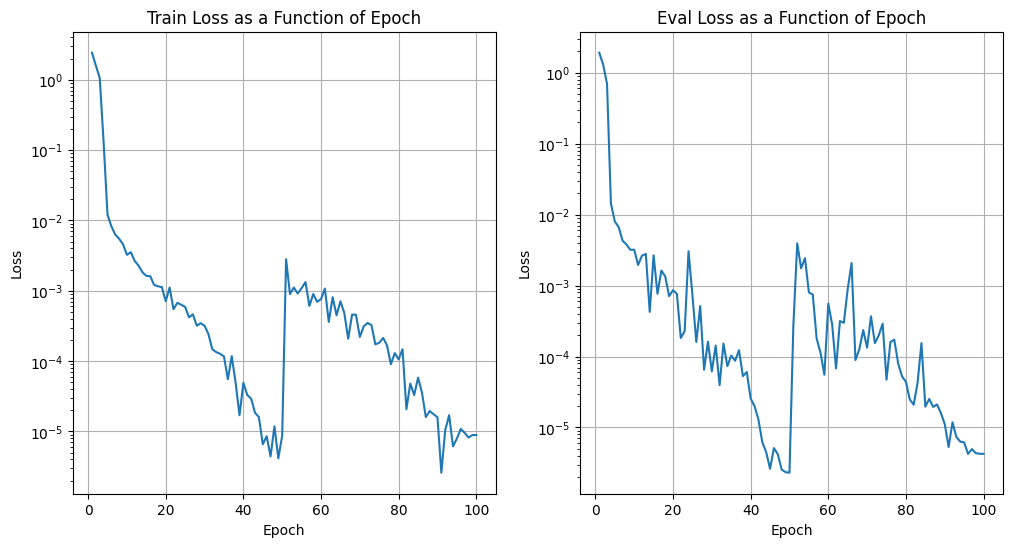

In [16]:
metrics = [
    train_losses, eval_losses
]

titles = [
    'Train Loss as a Function of Epoch',
    'Eval Loss as a Function of Epoch'
]

plt.figure(figsize=(12, 6))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(np.arange(len(metrics[i])) + 1, metrics[i])
    plt.yscale('log')
    plt.title(titles[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

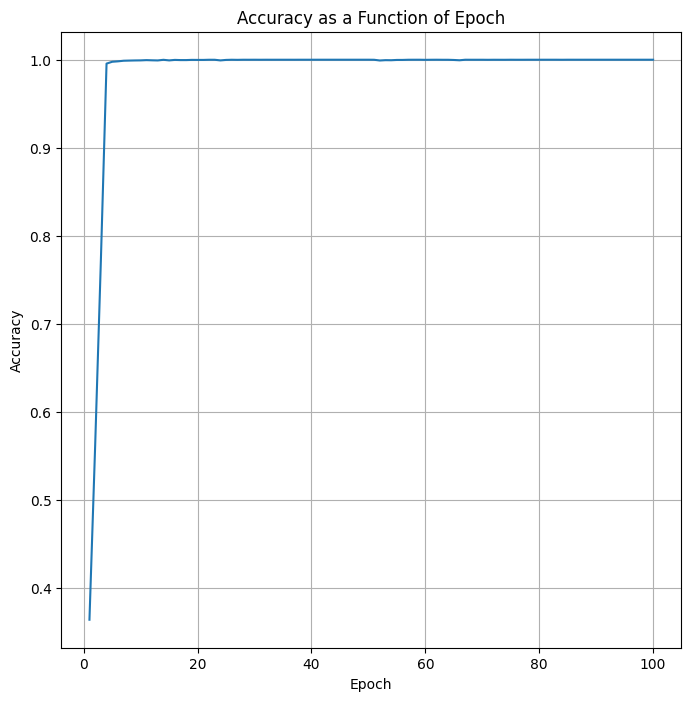

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(len(accuracies)) + 1, accuracies)
plt.title('Accuracy as a Function of Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

In [18]:
pd.DataFrame(
    zip(
        train_losses, 
        eval_losses, 
        accuracies
    ),
    columns=['train_loss', 'eval_loss', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('training_metrics', f'{model_name}.csv'), index=False)

In [19]:
model_path = os.path.join('trained', f'{model_name}.pt')
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

logger.info("Loaded The Model's Dict")

INFO:utils:Loaded The Model's Dict


In [20]:
accuracy = eval_accuracy(model, test_loader, DEVICE, min_len=16, max_len=1024, ignore_index=-1)

100%|██████████| 625/625 [00:04<00:00, 134.37it/s]


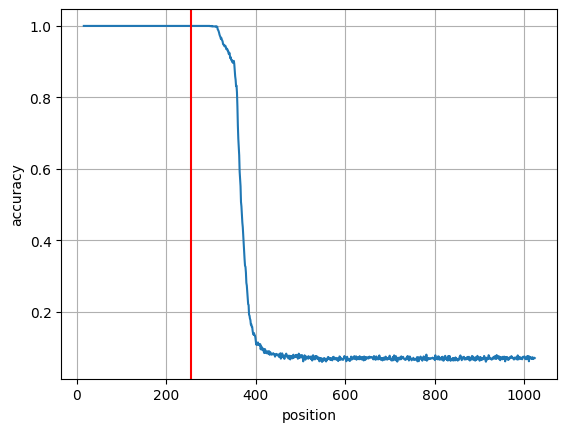

In [21]:
plt.plot(np.arange(16, len(accuracy)+16), accuracy.cpu().detach().numpy())
plt.grid()
plt.xlabel('position')
plt.ylabel('accuracy')
plt.axvline(256, color='r')

In [22]:
pd.DataFrame(
    zip(
        np.arange(16, len(accuracy)+16), 
        accuracy.cpu().detach().numpy(), 
    ),
    columns=['position', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('metrics', f'{model_name}.csv'), index=False)

# T5 Relative Bias

In [9]:
from t5_relative import GPTConfig, TransformerDecoder

In [10]:
config = GPTConfig(
    seq_len=1024,
    vocab_size_in=train_dataset.vocab_size,
    vocab_size_out=train_dataset.vocab_size,
    n_blocks=2,
    n_heads=8,
    d_model=128,
    n_buckets=32,
    is_causal=True,
    qkv_bias=True
)

model_name = 't5_relative'
DEVICE = "cuda:0"
model = TransformerDecoder(config).to(DEVICE)
logger.info(count_parameters(model))

INFO:utils:401424


In [11]:
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=1024, 
    num_training_steps=100 * 1024,
    num_cycles=2
)

In [12]:
train_losses, eval_losses, accuracies = train(
    model, 
    optimizer, 
    loss_fn,
    train_loader, 
    val_loader,
    DEVICE,
    scheduler=scheduler, 
    epochs=100,
    model_path=os.path.join('trained', f'{model_name}.pt')
)

100%|██████████| 256/256 [00:01<00:00, 166.82it/s]
INFO:utils:Loss_epoch 1: 2.6256005028262734
INFO:utils:Loss_eval 1: 2.5327346585690975
INFO:utils:Accuracy 1: 0.16300862630208332
100%|██████████| 256/256 [00:01<00:00, 180.05it/s]
INFO:utils:Loss_epoch 2: 2.2307473341934383
INFO:utils:Loss_eval 2: 1.9928186354227364
INFO:utils:Accuracy 2: 0.2777323404947917
100%|██████████| 256/256 [00:01<00:00, 175.11it/s]
INFO:utils:Loss_epoch 3: 1.8910640220856294
INFO:utils:Loss_eval 3: 1.8114624661393464
INFO:utils:Accuracy 3: 0.3455891927083333
100%|██████████| 256/256 [00:01<00:00, 174.64it/s]
INFO:utils:Loss_epoch 4: 1.7694904555100948
INFO:utils:Loss_eval 4: 1.7213764199987054
INFO:utils:Accuracy 4: 0.3745808919270833
100%|██████████| 256/256 [00:01<00:00, 171.19it/s]
INFO:utils:Loss_epoch 5: 1.6412367179291323
INFO:utils:Loss_eval 5: 1.5323206298053265
INFO:utils:Accuracy 5: 0.45425211588541664
100%|██████████| 256/256 [00:01<00:00, 175.00it/s]
INFO:utils:Loss_epoch 6: 1.4558663086500019
INF

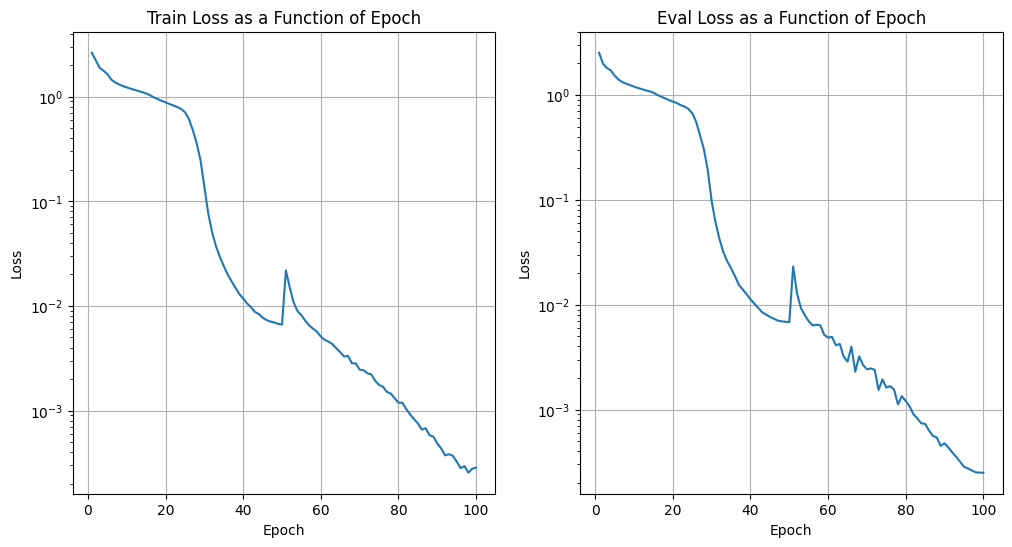

In [13]:
metrics = [
    train_losses, eval_losses
]

titles = [
    'Train Loss as a Function of Epoch',
    'Eval Loss as a Function of Epoch'
]

plt.figure(figsize=(12, 6))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(np.arange(len(metrics[i])) + 1, metrics[i])
    plt.yscale('log')
    plt.title(titles[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

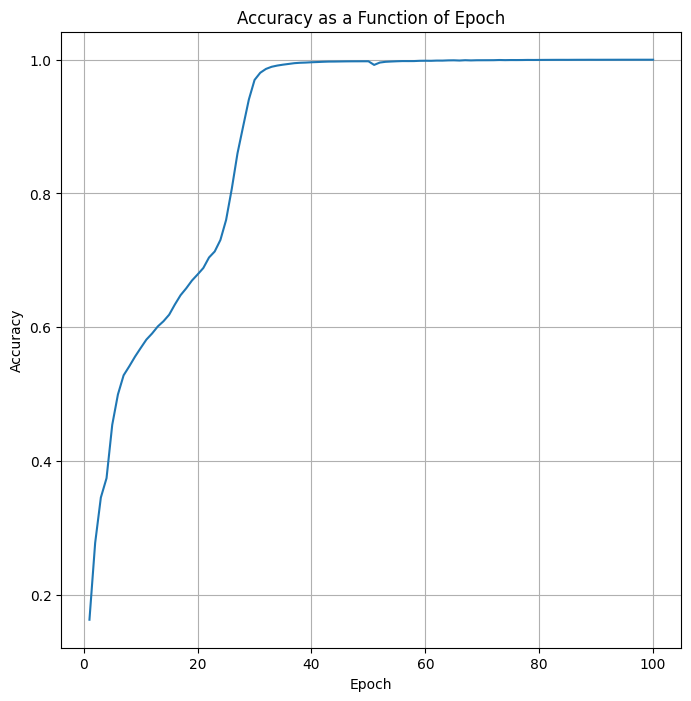

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(len(accuracies)) + 1, accuracies)
plt.title('Accuracy as a Function of Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

In [15]:
pd.DataFrame(
    zip(
        train_losses, 
        eval_losses, 
        accuracies
    ),
    columns=['train_loss', 'eval_loss', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('training_metrics', f'{model_name}.csv'), index=False)

In [16]:
model_path = os.path.join('trained', f'{model_name}.pt')
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

logger.info("Loaded The Model's Dict")

INFO:utils:Loaded The Model's Dict


In [17]:
accuracy = eval_accuracy(model, test_loader, DEVICE, min_len=16, max_len=1024, ignore_index=-1)

100%|██████████| 625/625 [00:31<00:00, 20.01it/s]


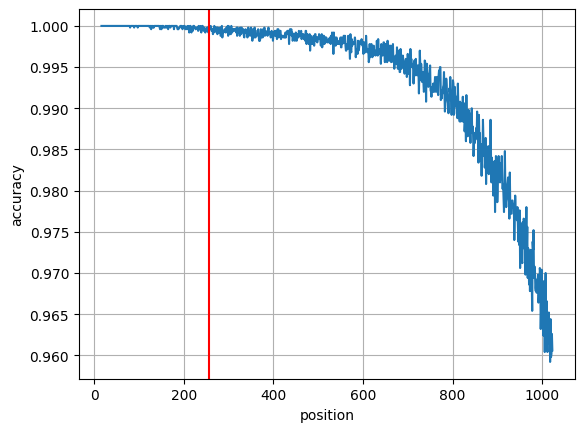

In [18]:
plt.plot(np.arange(16, len(accuracy)+16), accuracy.cpu().detach().numpy())
plt.grid()
plt.xlabel('position')
plt.ylabel('accuracy')
plt.axvline(256, color='r')

In [19]:
pd.DataFrame(
    zip(
        np.arange(16, len(accuracy)+16), 
        accuracy.cpu().detach().numpy(), 
    ),
    columns=['position', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('metrics', f'{model_name}.csv'), index=False)

# No Positional Embedding

In [9]:
from no_pos import GPTConfig, TransformerDecoder

In [10]:
config = GPTConfig(
    seq_len=1024,
    vocab_size_in=train_dataset.vocab_size,
    vocab_size_out=train_dataset.vocab_size,
    n_blocks=2,
    n_heads=8,
    d_model=128,
    is_causal=True,
    qkv_bias=True
)

model_name = 'no_pos'
DEVICE = "cuda:0"
model = TransformerDecoder(config).to(DEVICE)
logger.info(count_parameters(model))

INFO:utils:400912


In [11]:
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=1024, 
    num_training_steps=200 * 1024,
    num_cycles=2
)

In [12]:
train_losses, eval_losses, accuracies = train(
    model, 
    optimizer, 
    loss_fn,
    train_loader, 
    val_loader,
    DEVICE,
    scheduler=scheduler, 
    epochs=200,
    model_path=os.path.join('trained', f'{model_name}.pt')
)

100%|██████████| 256/256 [00:00<00:00, 315.89it/s]
INFO:utils:Loss_epoch 1: 2.6347814919427037
INFO:utils:Loss_eval 1: 2.5643128864467144
INFO:utils:Accuracy 1: 0.15448201497395833
100%|██████████| 256/256 [00:00<00:00, 329.63it/s]
INFO:utils:Loss_epoch 2: 2.505143447779119
INFO:utils:Loss_eval 2: 2.3578529581427574
INFO:utils:Accuracy 2: 0.21764322916666667
100%|██████████| 256/256 [00:00<00:00, 331.68it/s]
INFO:utils:Loss_epoch 3: 2.2551866974681616
INFO:utils:Loss_eval 3: 2.1919977236539125
INFO:utils:Accuracy 3: 0.25812174479166666
100%|██████████| 256/256 [00:00<00:00, 334.01it/s]
INFO:utils:Loss_epoch 4: 2.1531217365991324
INFO:utils:Loss_eval 4: 2.1142959678545594
INFO:utils:Accuracy 4: 0.27206013997395834
100%|██████████| 256/256 [00:00<00:00, 333.16it/s]
INFO:utils:Loss_epoch 5: 2.0932337008416653
INFO:utils:Loss_eval 5: 2.0698625068180263
INFO:utils:Accuracy 5: 0.28248697916666665
100%|██████████| 256/256 [00:00<00:00, 351.34it/s]
INFO:utils:Loss_epoch 6: 2.056226746411994
IN

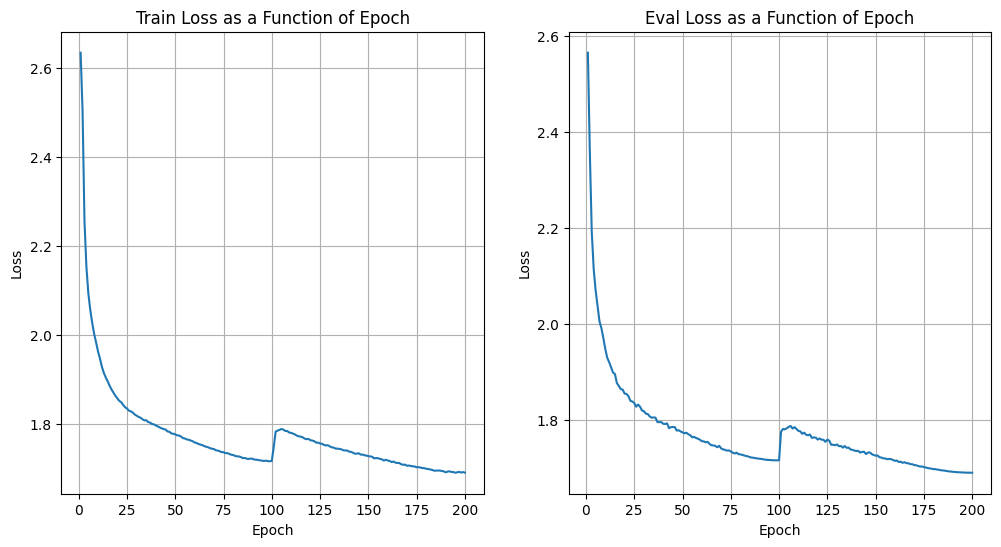

In [18]:
metrics = [
    train_losses, eval_losses
]

titles = [
    'Train Loss as a Function of Epoch',
    'Eval Loss as a Function of Epoch'
]

plt.figure(figsize=(12, 6))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(np.arange(len(metrics[i])) + 1, metrics[i])
    plt.title(titles[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

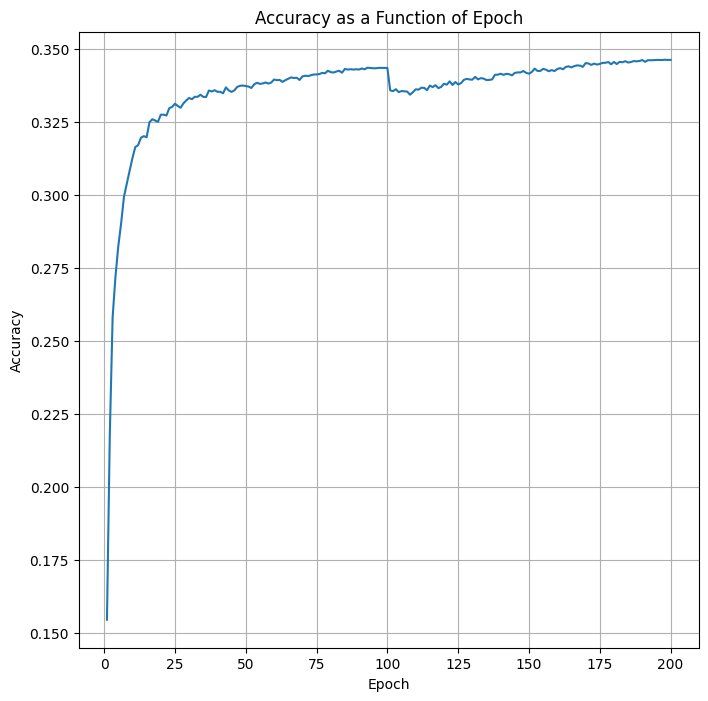

In [16]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(len(accuracies)) + 1, accuracies)
plt.title('Accuracy as a Function of Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

In [19]:
pd.DataFrame(
    zip(
        train_losses, 
        eval_losses, 
        accuracies
    ),
    columns=['train_loss', 'eval_loss', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('training_metrics', f'{model_name}.csv'), index=False)

In [20]:
model_path = os.path.join('trained', f'{model_name}.pt')
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

logger.info("Loaded The Model's Dict")

INFO:utils:Loaded The Model's Dict


In [21]:
accuracy = eval_accuracy(model, test_loader, DEVICE, min_len=16, max_len=1024, ignore_index=-1)

100%|██████████| 625/625 [00:04<00:00, 140.05it/s]


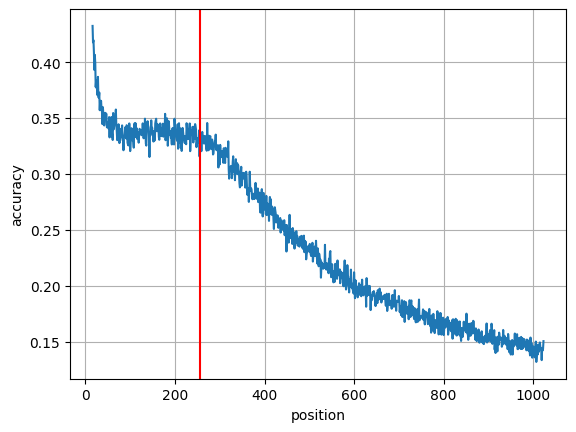

In [22]:
plt.plot(np.arange(16, len(accuracy)+16), accuracy.cpu().detach().numpy())
plt.grid()
plt.xlabel('position')
plt.ylabel('accuracy')
plt.axvline(256, color='r')

In [23]:
pd.DataFrame(
    zip(
        np.arange(16, len(accuracy)+16), 
        accuracy.cpu().detach().numpy(), 
    ),
    columns=['position', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('metrics', f'{model_name}.csv'), index=False)

# No Positional Embedding + BOS Token

In [9]:
from no_pos import GPTConfig, TransformerDecoder

In [10]:
config = GPTConfig(
    seq_len=1024,
    vocab_size_in=train_dataset.vocab_size,
    vocab_size_out=train_dataset.vocab_size,
    n_blocks=2,
    n_heads=8,
    d_model=128,
    is_causal=True,
    qkv_bias=True
)

model_name = 'no_pos_bos'
DEVICE = "cuda:0"
model = TransformerDecoder(config).to(DEVICE)
logger.info(count_parameters(model))

INFO:utils:401169


In [11]:
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=1024, 
    num_training_steps=200 * 1024,
    num_cycles=2
)

In [12]:
train_losses, eval_losses, accuracies = train(
    model, 
    optimizer, 
    loss_fn,
    train_loader, 
    val_loader,
    DEVICE,
    scheduler=scheduler, 
    epochs=200,
    model_path=os.path.join('trained', f'{model_name}.pt')
)

100%|██████████| 256/256 [00:00<00:00, 313.07it/s]
INFO:utils:Loss_epoch 1: 2.6278896692674607
INFO:utils:Loss_eval 1: 2.528531244955957
INFO:utils:Accuracy 1: 0.16429646809895834
100%|██████████| 256/256 [00:00<00:00, 328.92it/s]
INFO:utils:Loss_epoch 2: 2.464661884587258
INFO:utils:Loss_eval 2: 2.4152482375502586
INFO:utils:Accuracy 2: 0.17501627604166667
100%|██████████| 256/256 [00:00<00:00, 325.20it/s]
INFO:utils:Loss_epoch 3: 2.33253689808771
INFO:utils:Loss_eval 3: 2.2533834846690297
INFO:utils:Accuracy 3: 0.21212361653645834
100%|██████████| 256/256 [00:00<00:00, 321.29it/s]
INFO:utils:Loss_epoch 4: 2.1282797370804474
INFO:utils:Loss_eval 4: 2.0322595834732056
INFO:utils:Accuracy 4: 0.2819722493489583
100%|██████████| 256/256 [00:00<00:00, 328.59it/s]
INFO:utils:Loss_epoch 5: 1.9813305486459285
INFO:utils:Loss_eval 5: 1.9129595952108502
INFO:utils:Accuracy 5: 0.3095703125
100%|██████████| 256/256 [00:00<00:00, 330.05it/s]
INFO:utils:Loss_epoch 6: 1.9146356139099225
INFO:utils:L

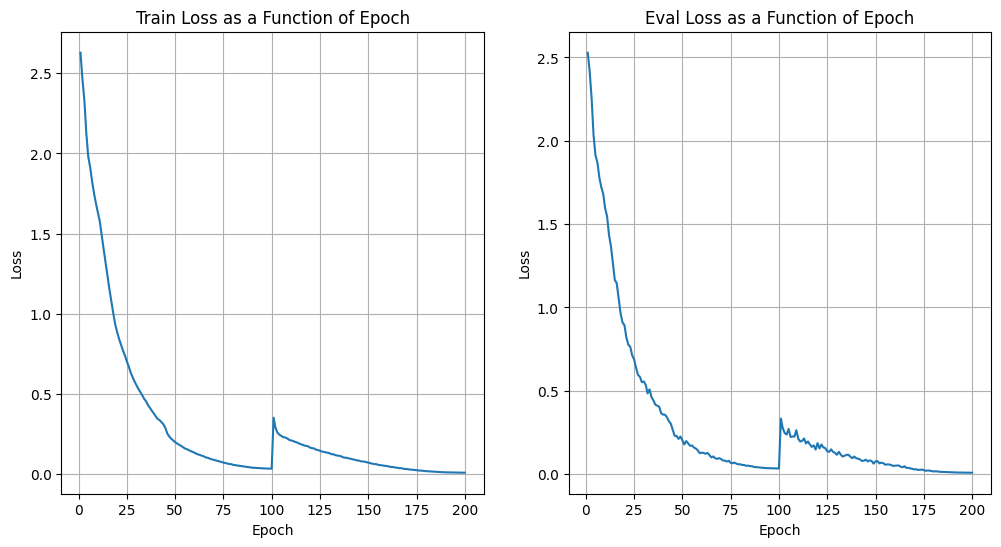

In [13]:
metrics = [
    train_losses, eval_losses
]

titles = [
    'Train Loss as a Function of Epoch',
    'Eval Loss as a Function of Epoch'
]

plt.figure(figsize=(12, 6))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(np.arange(len(metrics[i])) + 1, metrics[i])
    plt.title(titles[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

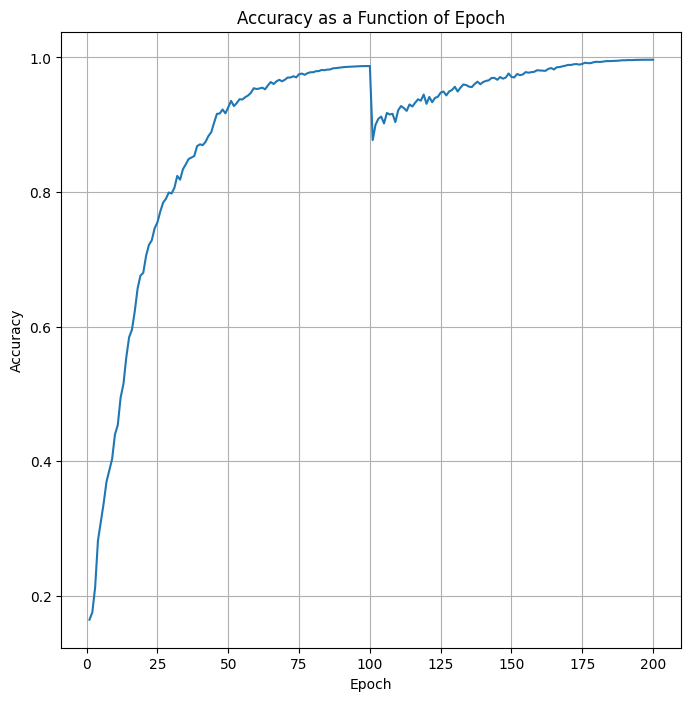

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(len(accuracies)) + 1, accuracies)
plt.title('Accuracy as a Function of Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

In [15]:
pd.DataFrame(
    zip(
        train_losses, 
        eval_losses, 
        accuracies
    ),
    columns=['train_loss', 'eval_loss', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('training_metrics', f'{model_name}.csv'), index=False)

In [16]:
model_path = os.path.join('trained', f'{model_name}.pt')
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

logger.info("Loaded The Model's Dict")

INFO:utils:Loaded The Model's Dict


In [17]:
accuracy = eval_accuracy(model, test_loader, DEVICE, min_len=16, max_len=1024, ignore_index=-1)

100%|██████████| 625/625 [00:04<00:00, 131.59it/s]


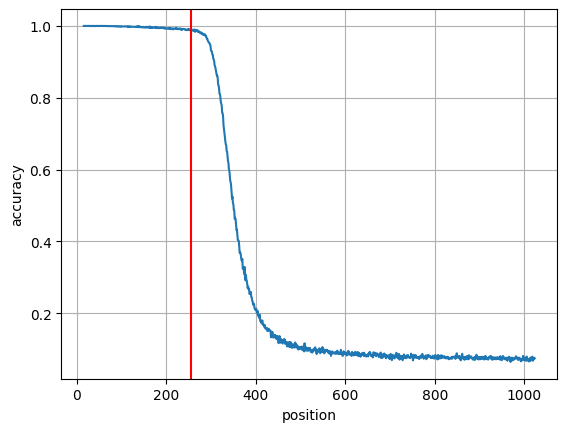

In [18]:
plt.plot(np.arange(16, len(accuracy)+16), accuracy.cpu().detach().numpy())
plt.grid()
plt.xlabel('position')
plt.ylabel('accuracy')
plt.axvline(256, color='r')

In [19]:
pd.DataFrame(
    zip(
        np.arange(16, len(accuracy)+16), 
        accuracy.cpu().detach().numpy(), 
    ),
    columns=['position', 'accuracy']
).assign(model_name=model_name)\
        .to_csv(os.path.join('metrics', f'{model_name}.csv'), index=False)